# General imports

In [ ]:
from pathlib import Path

import ipywidgets as widgets
import mdtraj
import nglview
import numpy
import numpy as np
import openmm
import openmm.unit as omm_unit
import rdkit
from openff.interchange import Interchange
from openff.interchange.drivers.openmm import get_openmm_energies
from openff.toolkit import AmberToolsToolkitWrapper, ForceField, Molecule, Topology
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper
from openff.units import Quantity, ensure_quantity, unit
from openff.units.openmm import from_openmm
from openmm.app import Simulation
from pdbfixer import PDBFixer

# Warm up NAGL
ntkw = NAGLToolkitWrapper()
ntkw.assign_partial_charges(Molecule.from_smiles('C'), "openff-gnn-am1bcc-0.1.0-rc.3.pt")

# RDKit UGM 2025 OpenFF Demo
## From RDKit to MD simulation in seconds
#### Assign parameters to a molecule from SDF

In [ ]:
rdmol = rdkit.Chem.MolFromMolFile("aspirin.sdf")
rdmol

In [ ]:
offmol = Molecule.from_rdkit(rdmol)
forcefield = ForceField("openff-2.2.1.offxml")
interchange = forcefield.create_interchange(offmol.to_topology())
interchange

In [ ]:
interchange.to_openmm()

#### Run and visualize a standard OpenMM simulation

In [ ]:
def simulate_and_visualize(interchange):
    # OpenMM setup boilerplate
    integrator = openmm.LangevinMiddleIntegrator(
            300 * omm_unit.kelvin,
            1 / omm_unit.picosecond,
            0.002 * omm_unit.picoseconds,
        )
    
    simulation = interchange.to_openmm_simulation(integrator)
    simulation.minimizeEnergy(tolerance=100)
    dcd_reporter = openmm.app.DCDReporter(file="trajectory.dcd", 
                                          reportInterval=10
                                         )
    simulation.reporters.append(dcd_reporter)
    simulation.step(1000)
    # Visualize the trakectory
    trajectory: mdtraj.Trajectory = mdtraj.load(
        "trajectory.dcd", top=mdtraj.Topology.from_openmm(interchange.to_openmm_topology())
    )
    view = nglview.show_mdtraj(trajectory)
    view.add_representation("line", selection="protein")
    view.add_line(selection="water")
    return view

simulate_and_visualize(interchange)

## A brief intro to OpenFF objects, and setting up a protein-ligand simulation

In [ ]:
from openff.toolkit import ForceField, Molecule, Topology

top = Topology.from_pdb(
    "complex_topology.pdb",
    unique_molecules=[Molecule.from_smiles("c12c(Cl)cccc1sc(C(=O)[O-])c(Cl)2")],
)
protein = top.molecule(0)
ligand = top.molecule(1)
top.visualize()

In [ ]:
# Solvate the topology
top.to_file('temp.pdb')
fixer = PDBFixer('temp.pdb')
fixer.addSolvent(
    padding=0.5 * omm_unit.nanometer, ionicStrength=0.15 * omm_unit.molar
)

with open("receptor_solvated.pdb", "w") as f:
    openmm.app.PDBFile.writeFile(fixer.topology, fixer.positions, f)
top = Topology.from_pdb("receptor_solvated.pdb", 
                        unique_molecules=[top.molecule(1)])

In [ ]:
top.visualize()

In [ ]:
# NOTE: Hierarchical parameter application (last match wins)
ff = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml")
# NOTE: AM1BCC happens in the background using RDKit+AmberTools
interchange = ff.create_interchange(top)
integrator = openmm.LangevinMiddleIntegrator(
        300 * omm_unit.kelvin,
        1 / omm_unit.picosecond,
        0.002 * omm_unit.picoseconds,
    )

simulation = interchange.to_openmm_simulation(integrator)
simulation.minimizeEnergy(tolerance=100)
dcd_reporter = openmm.app.DCDReporter(file="trajectory.dcd", 
                                      reportInterval=10
                                     )
simulation.reporters.append(dcd_reporter)
simulation.step(1000)


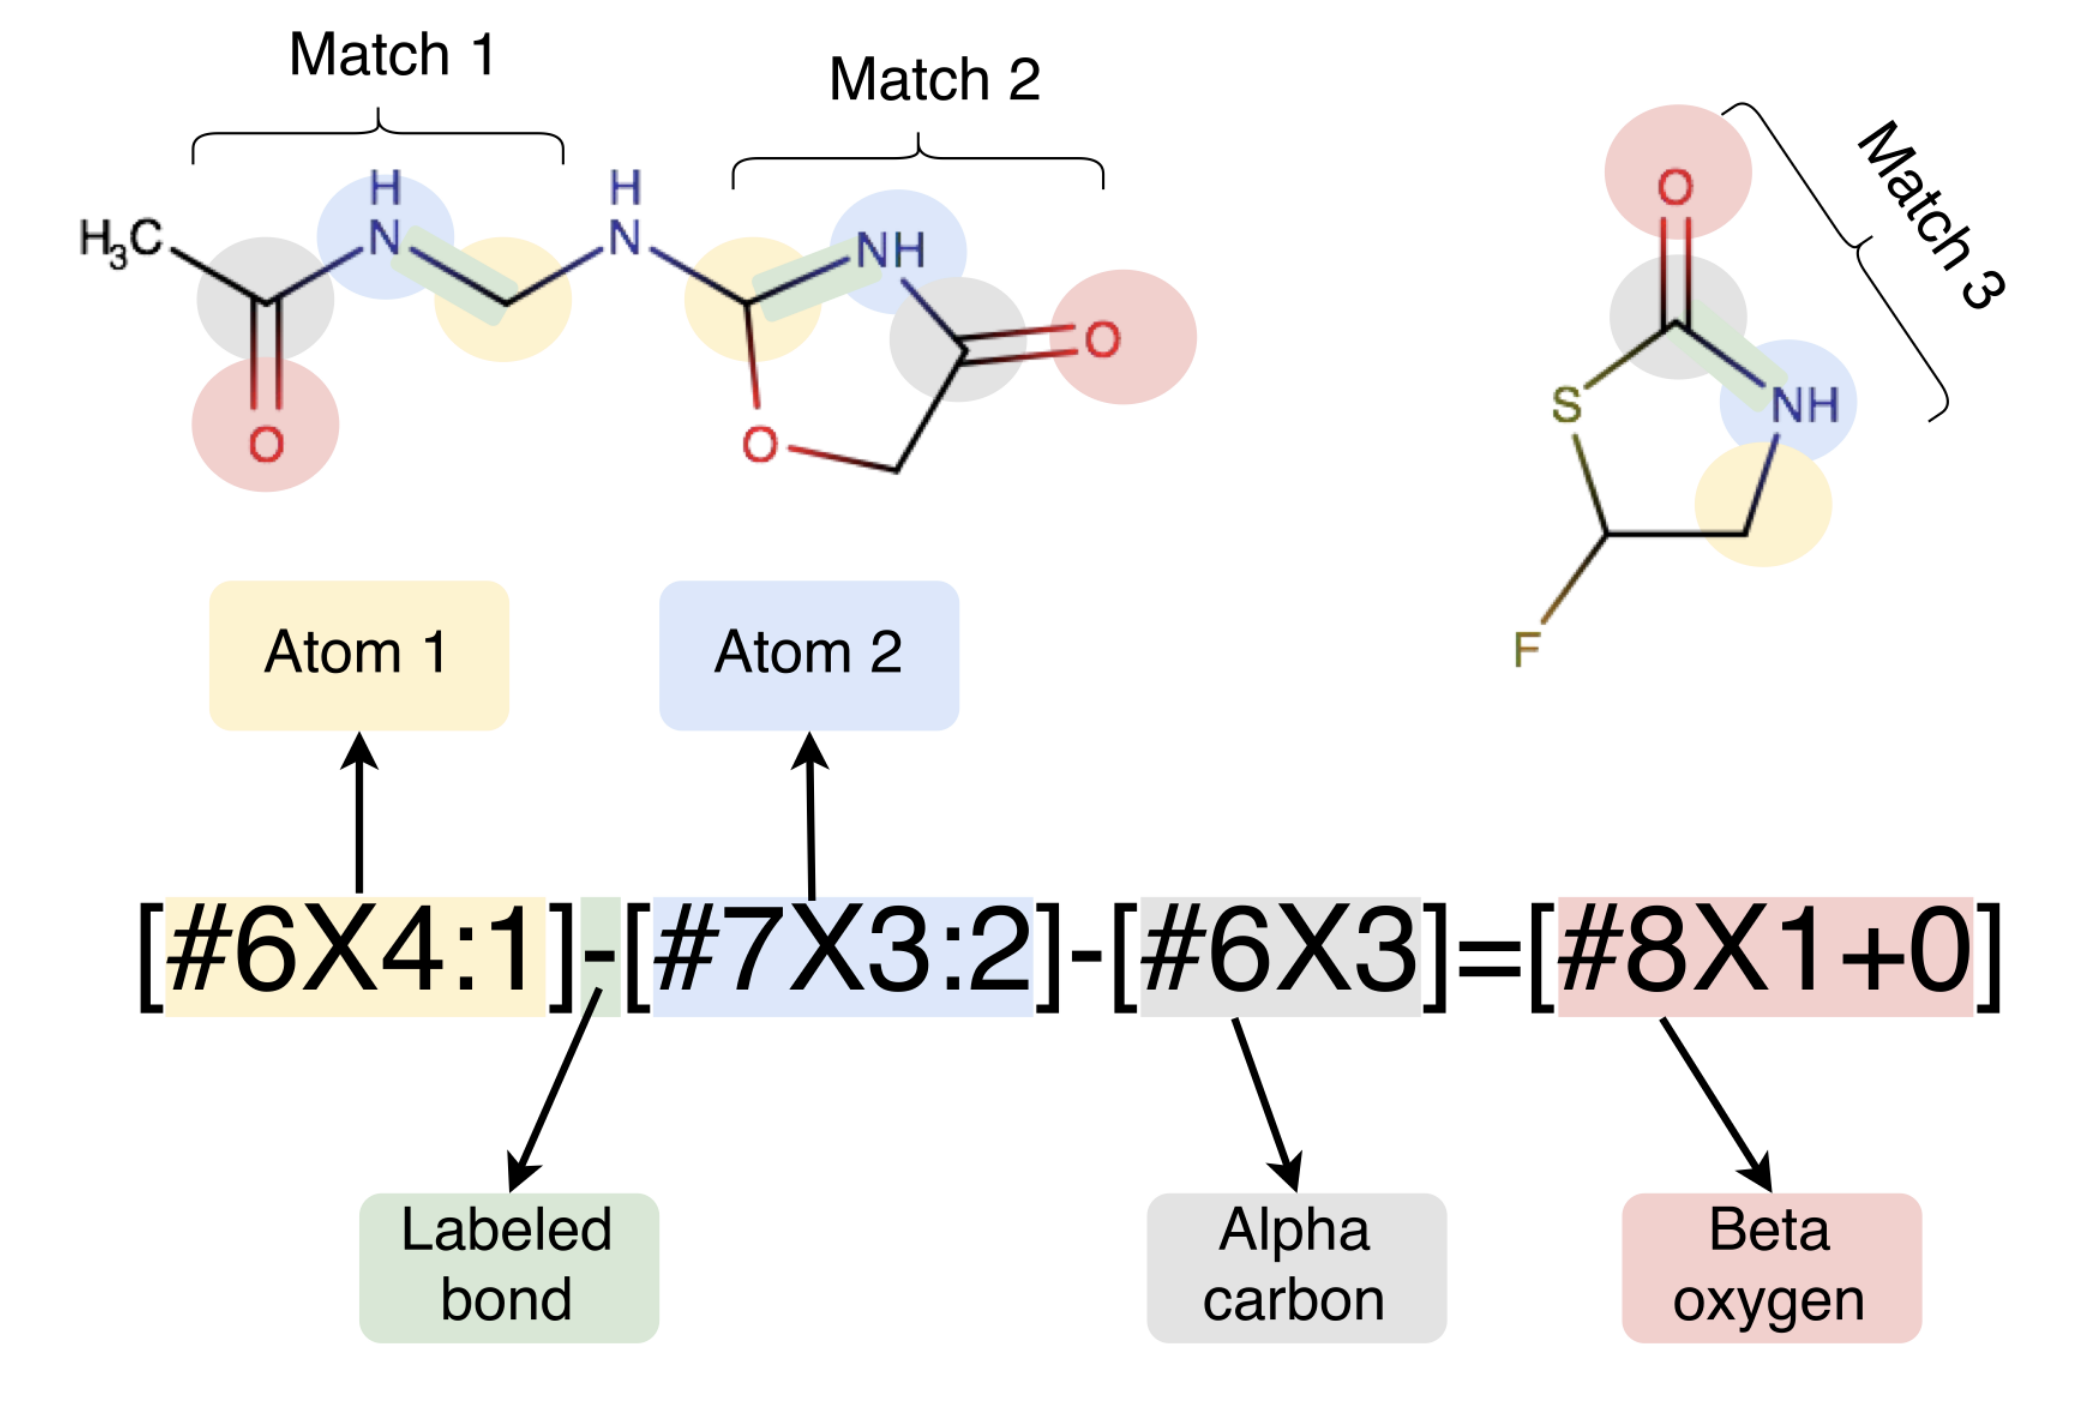
## Let's take a look at OpenFF-2.2.0



```
...

<Bond smirks="[#16X4,#16X3:1]~[#7:2]" id="b57" length="1.7177 A" k="351.2 kcal_per_mol A**-2"
<Bond smirks="[#16X4,#16X3:1]~[#7X2:2]" id="b57a" length="1.642 A" k="479.6 * kcal_per_mol A**-2"

...

Proper smirks="[*:1]-[#6X4:2]-[#6X3:3]=[*:4]" per="2" phase="0.0 degree" id="t18" k1="-0.447 * kcal_per_mol" 
Proper smirks="[*:1]-[#6X4:2]-[#6X3:3](~[#8X1])~[#8X1:4]" per="2" phase="0.0 degree " id="t18a" k1="-0.2045 * kcal_per_mol"
Proper smirks="[*:1]-[#6X4:2]-[#6X3:3](~!@[#7X3])~!@[#7X3:4]" per="2" phase="0.0 degree" id="t18b" k1="-0.1892 * kcal_per_mol"

...

<ToolkitAM1BCC version="0.3"></ToolkitAM1BCC>
```

In [ ]:
trajectory: mdtraj.Trajectory = mdtraj.load(
    "trajectory.dcd", top=mdtraj.Topology.from_openmm(interchange.to_openmm_topology())
)
view = nglview.show_mdtraj(trajectory.image_molecules())
view.add_representation("line", selection="protein")
view.add_line(selection="water")
view

* OpenFF can load PDBs consisting of the 20 canonical amino acids, waters, common salts, and user-defined small molecules. (So, relaxed openfold outputs are A-OK!)
* OpenFF force field application is hierarchical, so multiple force fields can be joined together. 
* OpenFF assigns partial charges using a fully open-source backend, leveraging RDKit and Ambertools.



## Do's and Don'ts of OpenFF's `from_rdkit` and `to_rdkit`

### DON'T have ambiguous stereochemistry

In [ ]:
rdmol = rdkit.Chem.MolFromSmiles("OC=CN")
rdmol

In [ ]:
offmol = Molecule.from_rdkit(rdmol)

In [ ]:
offmol = Molecule.from_rdkit(rdmol, allow_undefined_stereo=True)
offmol

In [ ]:
cis_rdmol = rdkit.Chem.MolFromSmiles(r"O/C=C\N")
cis_offmol = Molecule.from_rdkit(cis_rdmol)
cis_offmol.assign_partial_charges("am1bcc")
trans_rdmol = rdkit.Chem.MolFromSmiles(r"O/C=C/N")
trans_offmol = Molecule.from_rdkit(trans_rdmol)
trans_offmol.assign_partial_charges("am1bcc")
print(cis_offmol.partial_charges - trans_offmol.partial_charges)

### DO be very careful when loading from PDB files

In [ ]:
rdmol = rdkit.Chem.MolFromMolFile("linezolid_ambertools_charges.sdf")
rdmol

In [ ]:
rdmol = rdkit.Chem.MolFromPDBFile("linezolid_no_conect.pdb", proximityBonding=False)
rdmol

In [ ]:
rdmol = rdkit.Chem.MolFromPDBFile("linezolid_no_conect.pdb", proximityBonding=True)
rdmol

In [ ]:
rdmol = rdkit.Chem.MolFromPDBFile("linezolid_no_conect.pdb", proximityBonding=True, sanitize=False)
rdmol

In [ ]:
rdmol = rdkit.Chem.MolFromPDBFile("linezolid.pdb", proximityBonding=False)
rdmol

### DO ensure that each "molecule" is one fragment

In [ ]:
rdmol = rdkit.Chem.MolFromPDBFile("propane_methane_butanol_0.2_0.3_0.5.pdb")
rdmol

In [ ]:
top = Topology()
for frag in rdkit.Chem.GetMolFrags(rdmol, asMols=True):
    top.add_molecule(Molecule.from_rdkit(frag))
top.visualize()

In [ ]:
interchange = forcefield.create_interchange(top)
simulate_and_visualize(interchange)

### DO add explicit formal charge and bond orders

In [ ]:
bad_acetate_smiles = "C(O)O"
rdmol = rdkit.Chem.MolFromSmiles(bad_acetate_smiles)
offmol = Molecule.from_rdkit(rdmol)
offmol

In [ ]:
good_acetate_smiles = "C(=O)[O-]"
rdmol = rdkit.Chem.MolFromSmiles(good_acetate_smiles)
offmol = Molecule.from_rdkit(rdmol)
offmol

### DON'T try to simulate radicals (or incomplete molecules/substructures)

In [ ]:
rd_methyl_radical = rdkit.Chem.MolFromSmiles("[C]([H])([H])([H])")
rd_methyl_radical

In [ ]:
offmol.from_rdkit(rd_methyl_radical)

### DON'T try to simulate metals (we don't have bonded parameters or charge methods for them yet)

In [ ]:
rd_heme = rdkit.Chem.MolFromSmiles(r"OC(=O)CC/C6=C(\C)/C=3/N=C6/C=C2/C(/CCC(O)=O)=C(/C)\C1=C\C5=N\C(=C/c4n([Fe]N12)c(C=3)c(C=C)c4C)C(\C=C)=C5\C")
rd_heme

In [ ]:
off_heme = Molecule.from_rdkit(rd_heme)
interchange = forcefield.create_interchange(off_heme.to_topology())

### DO expect your aromaticity to be re-percieved using MDL

In [ ]:
rd_furan = rdkit.Chem.MolFromSmiles("c1cocc1")
rd_furan

In [ ]:
print(rd_furan.GetAtomWithIdx(0).GetIsAromatic())

In [ ]:
off_furan = Molecule.from_rdkit(rd_furan)
print(off_furan.atom(0).is_aromatic)

In [ ]:
print(off_furan.to_rdkit().GetAtomWithIdx(0).GetIsAromatic())

### DON'T treat coordinates as mandatory - They're optional!

In [ ]:
rd_ligand = rdkit.Chem.MolFromMolFile("posed_ligand.sdf")
off_ligand = Molecule.from_rdkit(rd_ligand)
interchange = forcefield.create_interchange(off_ligand.to_topology())
off_ligand

In [ ]:
simulate_and_visualize(interchange)

In [ ]:
rd_ligand = rdkit.Chem.MolFromMolFile("posed_ligand.sdf")
rd_ligand.RemoveAllConformers()
off_ligand = Molecule.from_rdkit(rd_ligand)
interchange = forcefield.create_interchange(off_ligand.to_topology())
interchange

In [ ]:
simulate_and_visualize(interchange)

### DO sanitize your molecules after running reactions RDKit

In [ ]:
ligand = Molecule.from_file("posed_ligand.sdf")
# NOTE: High quality interop with RDKit gives us access to a huge amount of functionality.
rdmol = ligand.to_rdkit()
reaction = "[#6:1]-[Cl:2] >> [*:1][N:2]"
rxn = rdkit.Chem.rdChemReactions.ReactionFromSmarts(reaction)
unsanitized_products = rxn.RunReactants([rdmol])
unsanitized_products[0][0]

In [ ]:
Molecule.from_rdkit(unsanitized_products[0][0])

In [ ]:
products = list()
for (product,) in unsanitized_products:
    mol_copy = rdkit.Chem.Mol(product)

    rdkit.Chem.SanitizeMol(mol_copy, rdkit.Chem.SANITIZE_ALL)
    rdkit.Chem.AssignStereochemistryFrom3D(mol_copy)
    rdkit.Chem.Kekulize(mol_copy, clearAromaticFlags=True)
    rdkit.Chem.SetAromaticity(mol_copy, rdkit.Chem.AromaticityModel.AROMATICITY_MDL)
    offmol = Molecule.from_rdkit(mol_copy)
    products.append(offmol)
products[0]

### DO read up on how molecule data is converted between RDKit and OpenFF 
(Atom order is guaranteed to remain constant when going between OpenFF and RDKit!)

In [ ]:
off_protein = Topology.from_pdb("selected_prediction_aligned.pdb").molecule(0)
off_protein.atom(0).name = "jim"
off_protein.atom(0).metadata['residue_number'] = 999
off_protein.properties["foo"] = "bar"

In [ ]:
rd_protein = off_protein.to_rdkit()
print(rd_protein.GetAtomWithIdx(0).GetPropsAsDict()["_Name"])
print(rd_protein.GetPropsAsDict()["foo"])
resinfo = rd_protein.GetAtomWithIdx(0).GetPDBResidueInfo()
print(resinfo.GetResidueName(), resinfo.GetResidueNumber(), resinfo.GetChainId())

# Check out our new prototype for simulating modified proteins

In [ ]:
import openmm
from ipywidgets import Image
from openff.interchange.components._packmol import (
    RHOMBIC_DODECAHEDRON,
    solvate_topology,
)
from openff.toolkit import ForceField, Molecule, Topology
from openff.units import Quantity
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE
from ptm_prototype import draw_molecule

cysteine = CCD_RESIDUE_DEFINITION_CACHE["CYS"][0].to_openff_molecule()


In [ ]:
thiol_maleimide_click_smarts = (
    "[C:10]-[S:1]-[H:2]"
    + "."
    + "[N:3]1-[C:4](=[O:5])-[C:6](-[H:11])=[C:7](-[H:12])-[C:8](=[O:9])-1"
    + ">>"
    + "[N:3]1-[C:4](=[O:5])-[C:6](-[H:2])(-[H:11])-[C@:7](-[S:1]-[C:10])(-[H:12])-[C:8](=[O:9])-1"
)

rxn = ReactionFromSmarts(thiol_maleimide_click_smarts)
d2d = Draw.MolDraw2DCairo(800, 300)
d2d.DrawReaction(
    ReactionFromSmarts(thiol_maleimide_click_smarts), highlightByReactant=True
)
Image(value=d2d.GetDrawingText())

In [ ]:
maleimide = Molecule.from_file("maleimide.sdf")
maleimide.generate_unique_atom_names()
from ptm_prototype import react

products = list(react([cysteine, maleimide], thiol_maleimide_click_smarts))
dye = products[0][0]
name_corrections = {
    4:  "H3x", 25: "C9x", 26: "H4x", 28: "C8x", 29: "H6x", 30: "H5x",
    32: "C10x", 33: "C11x", 34: "O2x", 35: "O3x", 36: "C23x", 37: "C12x",
    38: "C22x", 39: "C18x", 40: "C13x", 41: "C17x", 42: "H14x", 43: "C21x",
    44: "C19x", 45: "O5x", 46: "C14x", 47: "H7x", 49: "H13x", 50: "C20x",
    51: "H11x", 52: "C15x", 53: "H8x", 54: "H10x", 55: "O6x",
}
for i, name in name_corrections.items():
    dye.atom(i).name = name
from openff.pablo import ResidueDefinition
from openff.pablo.chem import PEPTIDE_BOND

dye_resdef = ResidueDefinition.from_molecule(
    molecule=dye,
    residue_name="DYE",
    linking_bond=PEPTIDE_BOND,
)
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE, topology_from_pdb

topology = topology_from_pdb(
    "3ip9_dye_solv.pdb",
    residue_database=CCD_RESIDUE_DEFINITION_CACHE.with_({"DYE": [dye_resdef]}),
)
w = topology.visualize()
w.clear_representations()
w.add_cartoon()
w.add_line(opacity=0.5, crossSize=1.0)
w.add_licorice("DYE", radius=0.3)
w.add_unitcell()
w.center("DYE")
w

In [ ]:
from ptm_prototype import parametrize_with_nagl

sage_ff14sb = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml")
interchange = parametrize_with_nagl(force_field=sage_ff14sb, topology=topology)

In [ ]:
w = simulate_and_visualize(interchange)
w.add_licorice("DYE", radius=0.3)
w.center("DYE")
w

In [ ]:
w

# A neat little visualization of iterative ligand design

In [ ]:

view = nglview.show_structure_file("relaxation_trajectory.pdb")
view.add_surface(
    selection="protein",
    opacity=0.5,
    opaqueBack=False,
)


def handler(change):
    view._remote_call(
        "setSelection",
        target="compList",
        args=[f"/{change['new']}"],
        kwargs=dict(component_index=0),
    )


play = widgets.Play(
    value=0,
    min=0,
    max=14,
    interval=500,
)
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=13,
)
slider.observe(handler, "value")
widgets.jslink((play, "value"), (slider, "value"))
controls = widgets.HBox([play, slider])
widgets.VBox([view, controls])

# A huge thanks to the RDKit organizers!

## For more examples, see [docs.openforcefield.org](docs.openforcefield.org)!

## To get a more detailed walkthrough of our current PTM simulation workflow, check out our [PTM prototype repo](https://github.com/openforcefield/ptm_prototype)

## To learn more about OpenFF, visit us at [openforcefield.org](openforcefield.org)!


# 
# 
# 
# 
# 
# 
# 
# 
# 
# 

# Making a ligand mutation design loop using RDKit

In [ ]:
view = nglview.show_structure_file("selected_prediction_aligned.pdb")
view.add_representation("surface", selection="protein", opacity=0.7, opaqueBack=False)
view.add_component("4hw3_D_aligned.pdb")
view


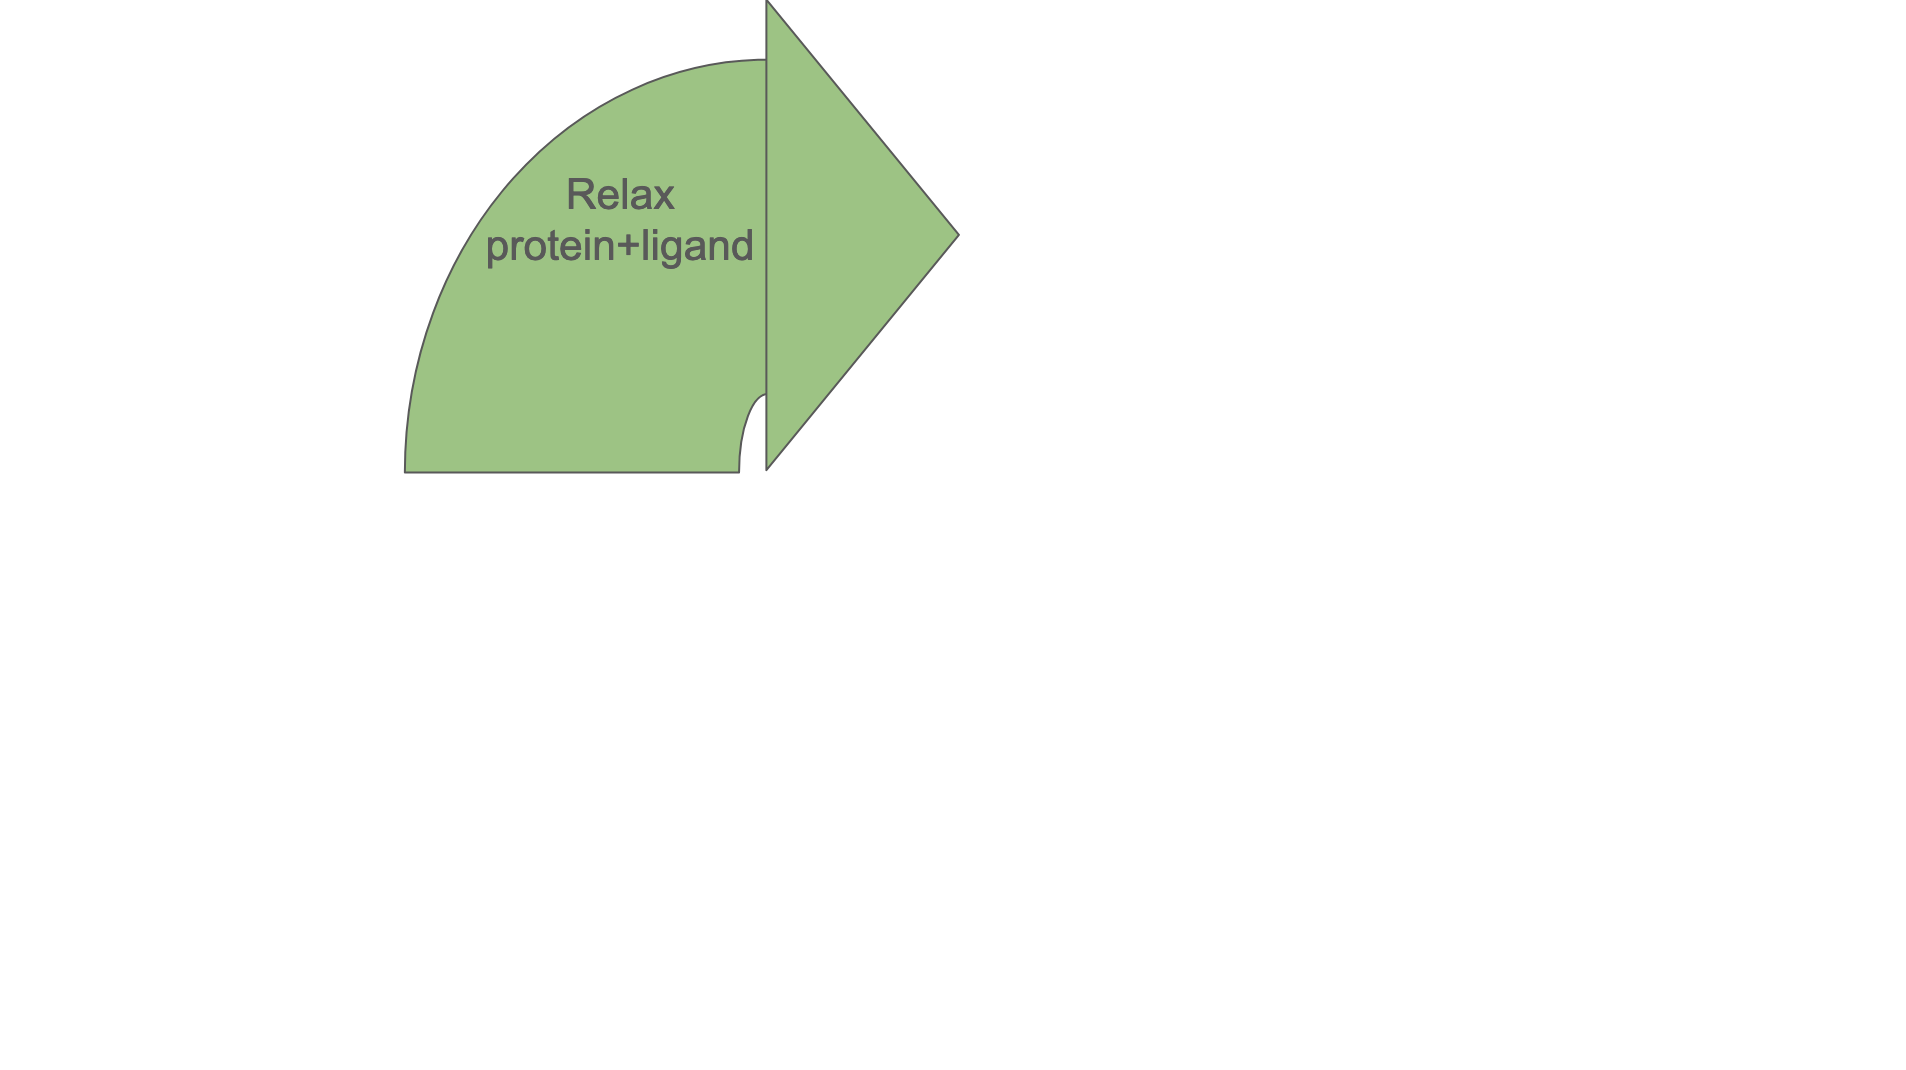

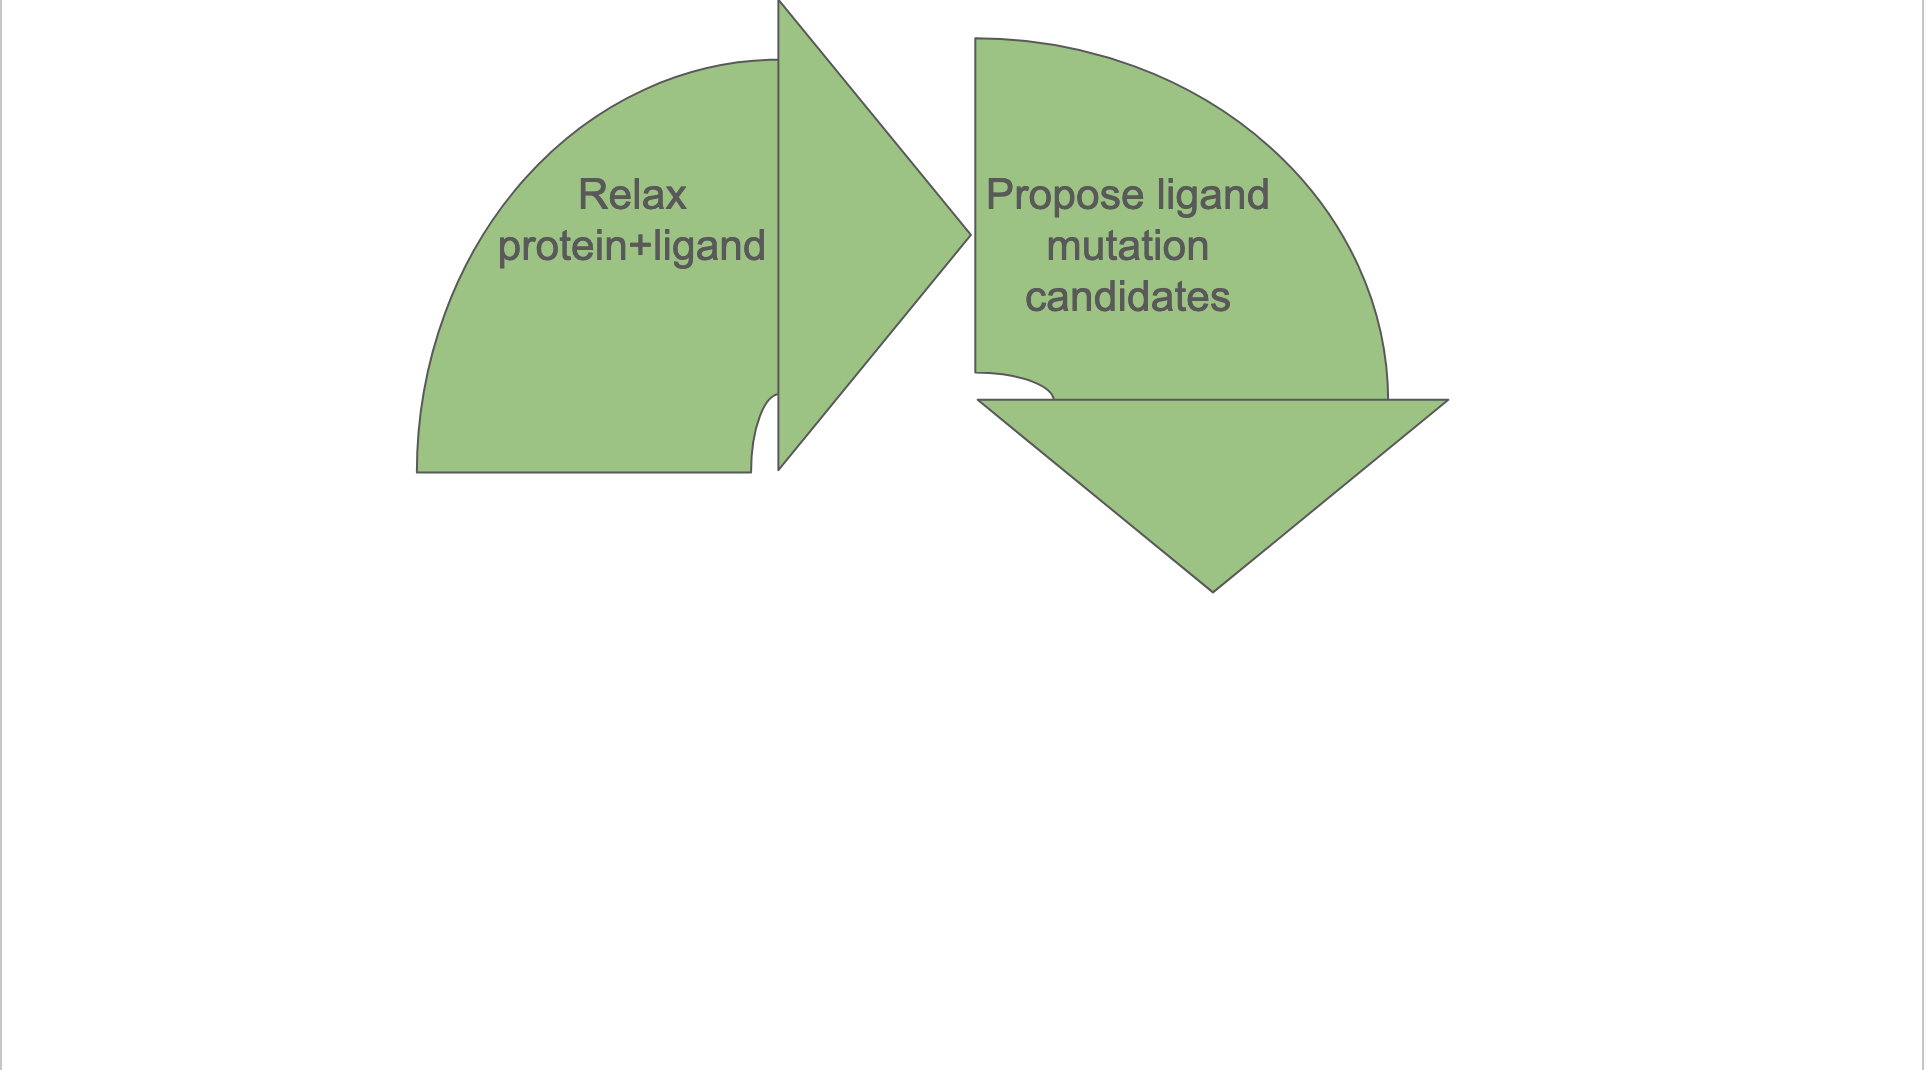

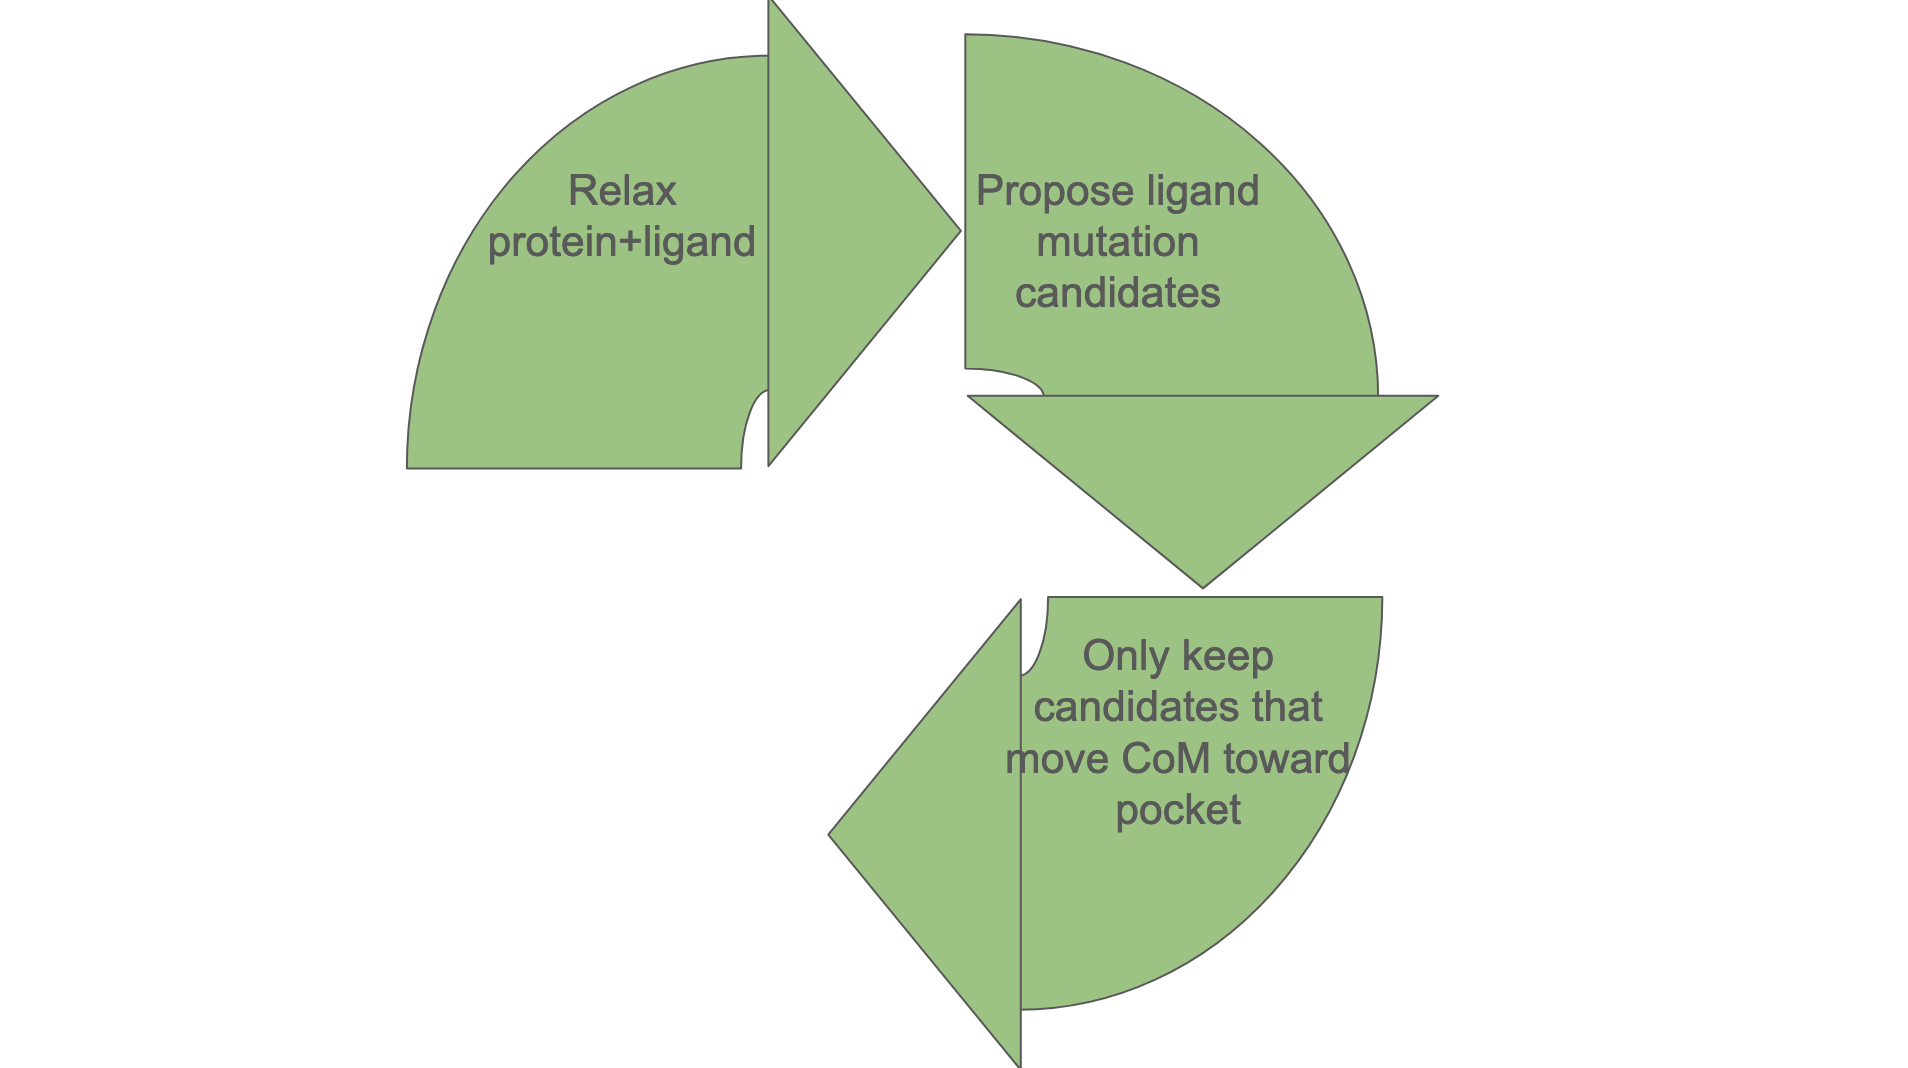

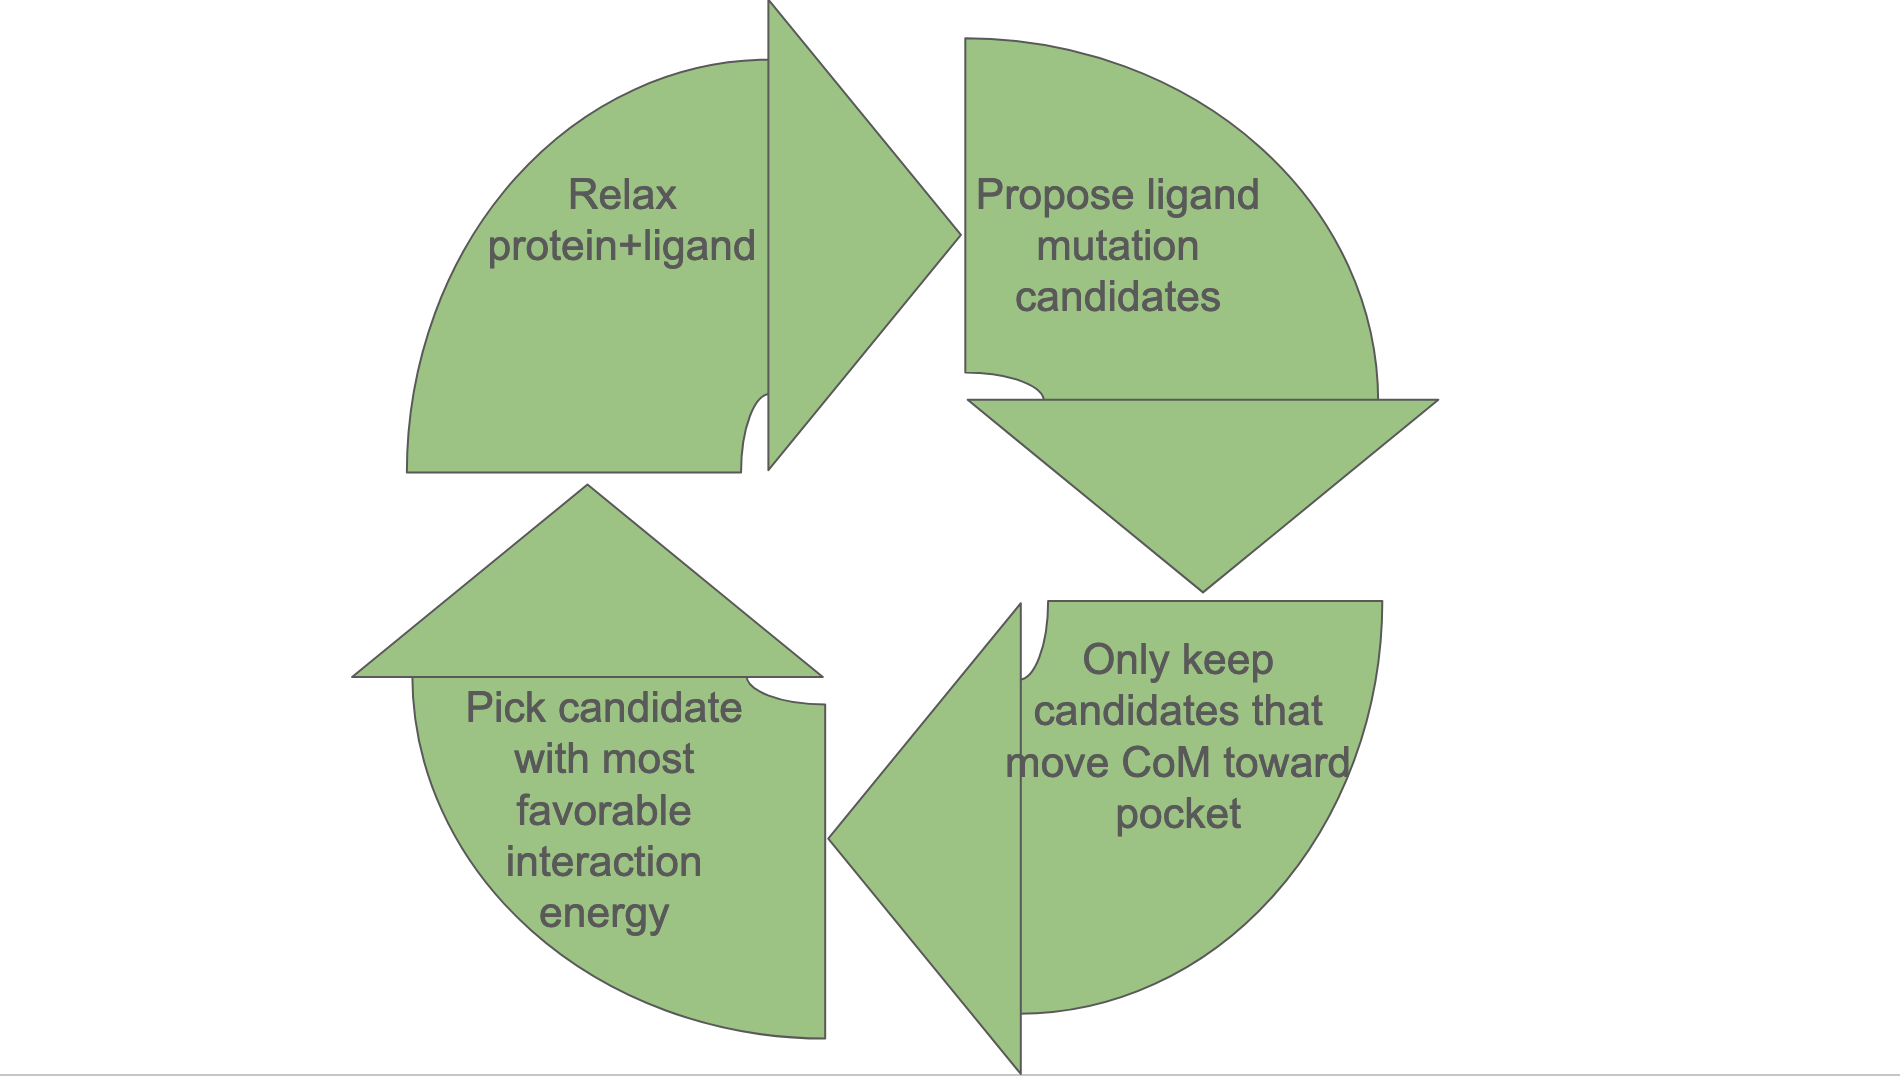



In [ ]:
top = Topology.from_pdb(
    "complex_topology.pdb",
    unique_molecules=[Molecule.from_smiles("c12c(Cl)cccc1sc(C(=O)[O-])c(Cl)2")],
)
protein = top.molecule(0)
ligand = top.molecule(1)
view = top.visualize()
view.add_representation("surface", selection="protein")
view

## Some boilerplate code for reuse

In [ ]:

def single_point_energy(
    simulation: Simulation, positions: Quantity, box_vectors: Quantity | None
) -> Quantity:
    """Calculate a single point energy with OpenMM"""
    simulation.context.setPositions(ensure_quantity(positions, "openmm"))
    if box_vectors is not None:
        simulation.context.setPeriodicBoxVectors(
            *ensure_quantity(box_vectors, "openmm")
        )
    state = simulation.context.getState(getEnergy=True)
    return ensure_quantity(state.getPotentialEnergy(), "openff")


def create_integrator() -> openmm.Integrator:
    return openmm.LangevinMiddleIntegrator(
        300 * omm_unit.kelvin,
        1 / omm_unit.picosecond,
        0.002 * omm_unit.picoseconds,
    )


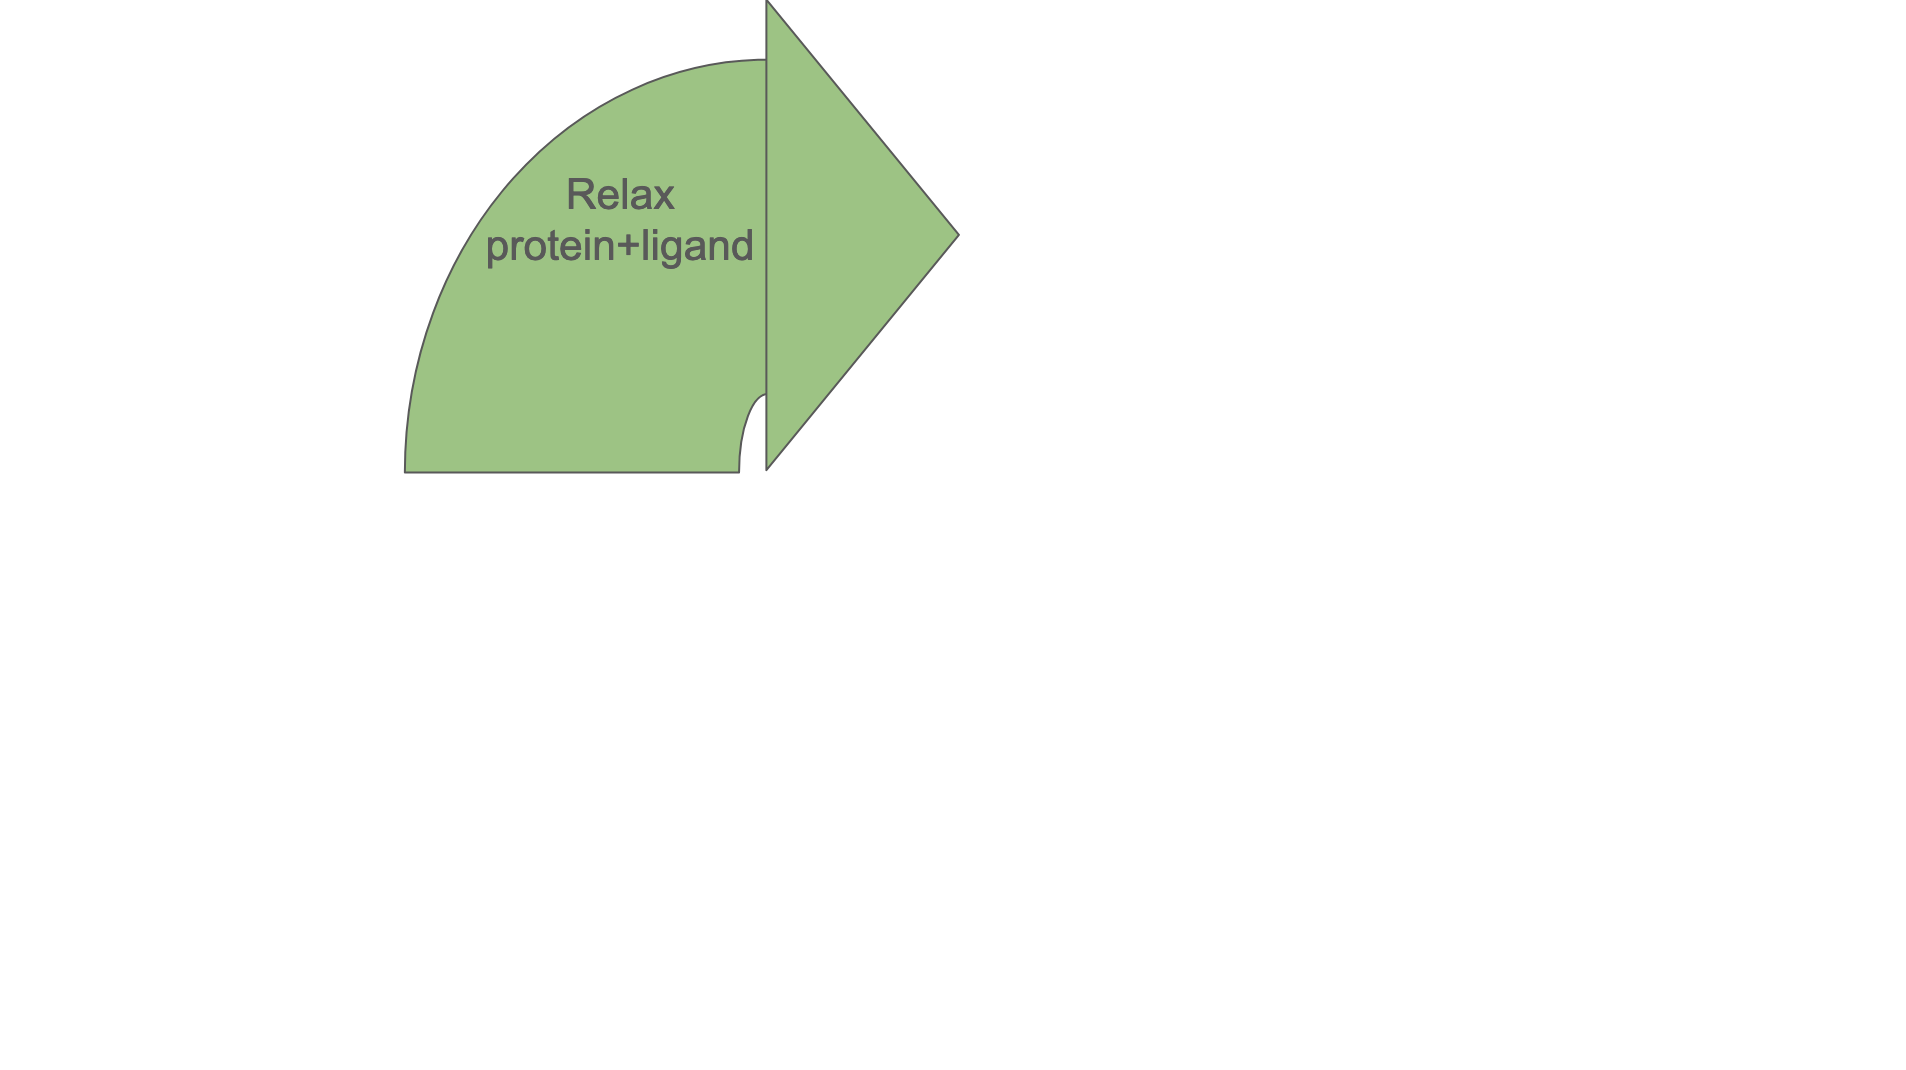

In [ ]:
sage = ForceField("openff-2.2.0.offxml")

ff14sb = ForceField("ff14sb_off_impropers_0.0.4.offxml")

# NOTE: We easily make a more clash-forgiving ligand FF for mutation candidate evaluation
softened_ff = ForceField("openff-2.2.0.offxml")
for parameter in softened_ff.get_parameter_handler("vdW"):
    parameter.rmin_half *= 0.5

In [ ]:
# NOTE: Interchange.combine lets us only make this expensive protein interchange once, and reuse it several times
protein_interchange = ff14sb.create_interchange(protein.to_topology())

In [ ]:
protein_simulation = protein_interchange.to_openmm_simulation(create_integrator())

In [ ]:
def relax_ligand(protein_interchange, ligand_offmol, ligand_ff, name=""):
    # Use NAGL to quickly charge the ligand
    ntkw = NAGLToolkitWrapper()
    ntkw.assign_partial_charges(ligand_offmol, "openff-gnn-am1bcc-0.1.0-rc.3.pt")
    ligand_interchange = sage.create_interchange(
        ligand_offmol.to_topology(), charge_from_molecules=[ligand_offmol]
    )
    # REUSE the protein interchange to make the complex
    complex_interchange = protein_interchange.combine(ligand_interchange)
    omm_sys = complex_interchange.to_openmm_system()
    omm_top = complex_interchange.to_openmm_topology()

    # "OPEN THE HOOD": Use OpenMM's API to apply restraints to backbone atoms and ligand scaffold
    restraint = openmm.CustomExternalForce("k*periodicdistance(x, y, z, x0, y0, z0)^2")
    omm_sys.addForce(restraint)
    restraint.addGlobalParameter(
        "k", 4000.0 * omm_unit.kilojoules_per_mole / omm_unit.angstrom
    )
    restraint.addPerParticleParameter("x0")
    restraint.addPerParticleParameter("y0")
    restraint.addPerParticleParameter("z0")

    for atom in omm_top.atoms():
        if atom.name in ["C", "O", "N", "CA", "S1X", "O1X", "O2X", "Cl1x", "Cl2x"]:
            restraint.addParticle(
                atom.index, complex_interchange.positions[atom.index].to_openmm()
            )
    # Minimize and run a short MD to relax the complex
    simulation = openmm.app.Simulation(omm_top, omm_sys, create_integrator())
    simulation.context.setPositions(complex_interchange.positions.to_openmm())
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(300)
    simulation.step(1000)

    # Copy the final simulation positions back to the complex_interchange object
    state = simulation.context.getState(
        getPositions=True, getForces=True, getEnergy=True
    )
    omm_positions = state.getPositions()
    openmm.app.PDBFile.writeFile(
        simulation.topology, omm_positions, open(f"{name}.pdb", "w")
    )

    complex_interchange.positions = from_openmm(omm_positions)

    return complex_interchange, state

In [ ]:
relaxed_interchange, state = relax_ligand(protein_interchange, ligand, sage, name="test")

view = nglview.show_file("test.pdb")
view.add_representation("surface", selection="protein")
view

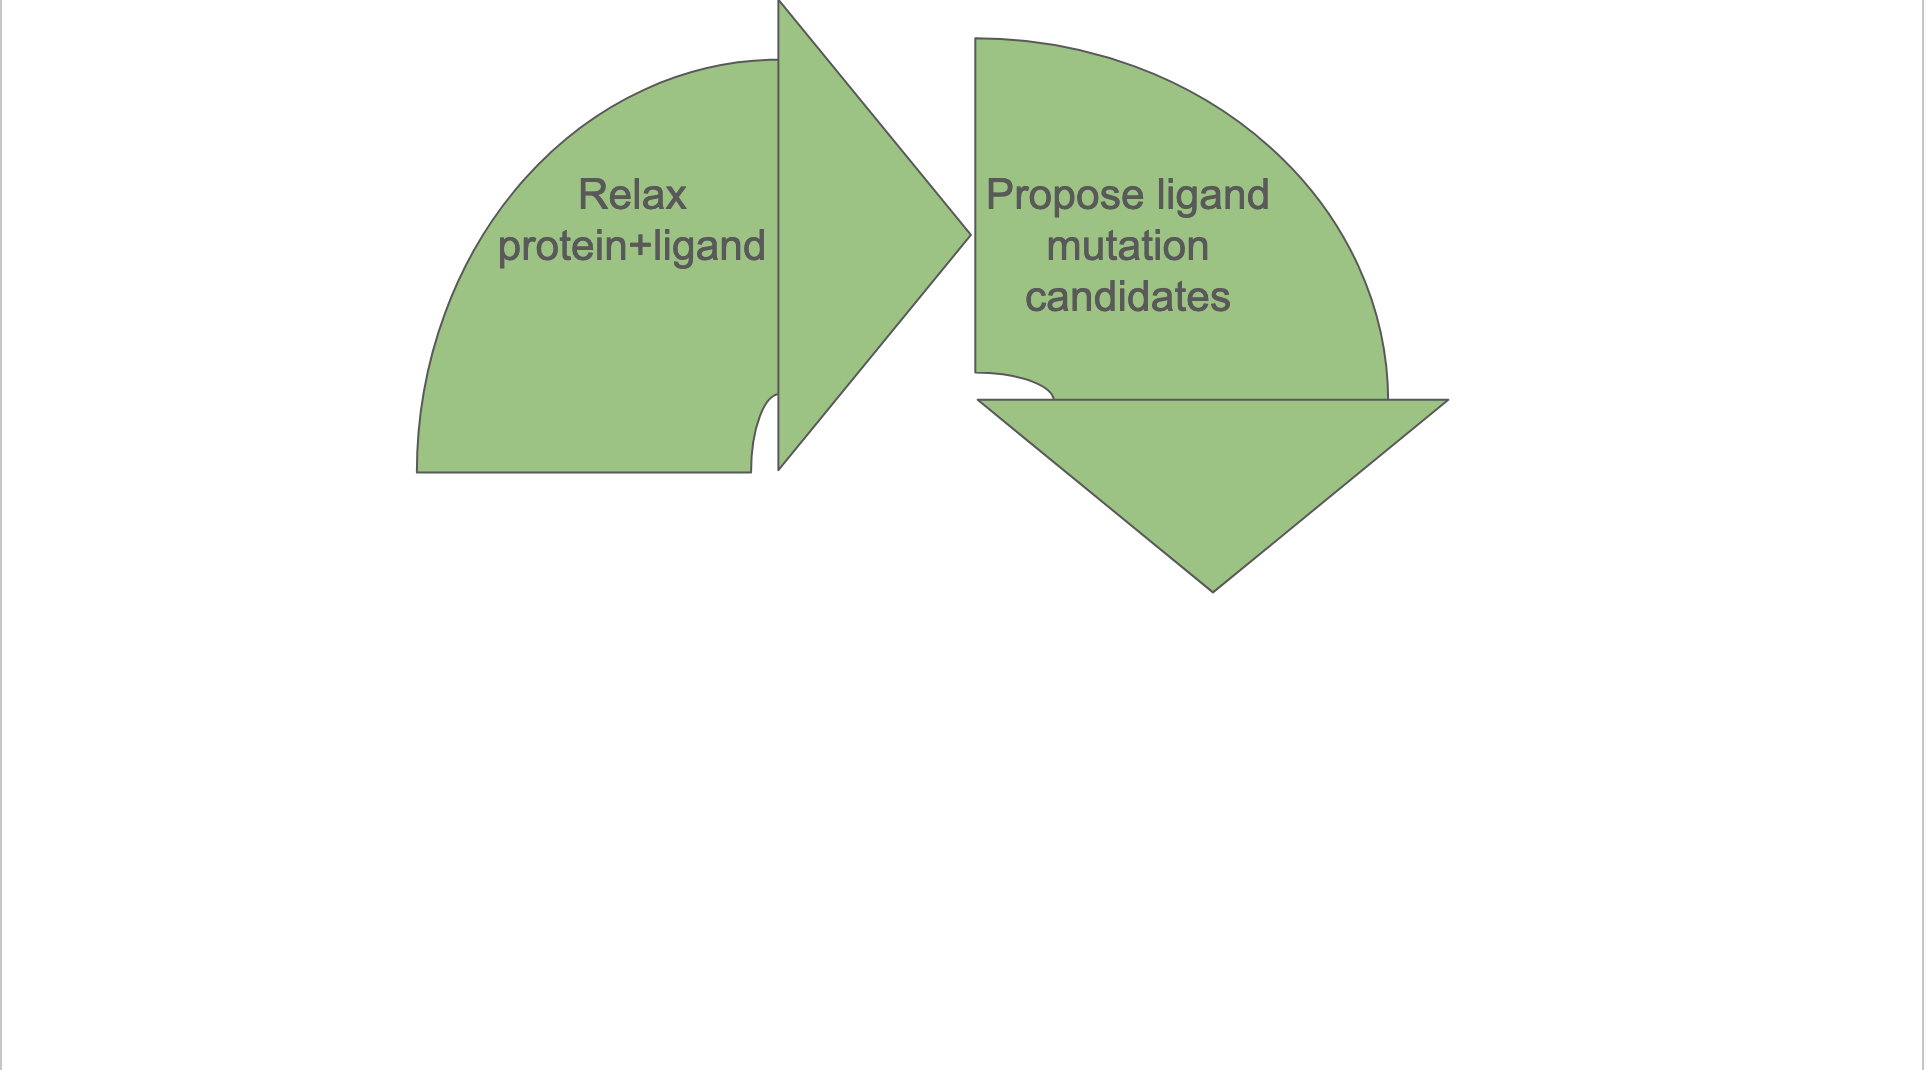

In [ ]:
def mutate_ligand(ligand):
    ligand.partial_charges = None
    # NOTE: High quality interop with RDKit gives us access to a huge amount of functionality.
    rdmol = ligand.to_rdkit()
    reactions = [
        "[*:1]-[*X1:2] >> [*:1][C:2]",
        "[#6:1]-[#1:2] >> [*:1][N:2]",
        "[#6:1]-[#1:2] >> [*:1][O:2]",
    ]
    unsanitized_products = []
    for reaction in reactions:
        rxn = rdkit.Chem.rdChemReactions.ReactionFromSmarts(reaction)
        unsanitized_products.extend(rxn.RunReactants([rdmol]))

    products = list()
    for (product,) in unsanitized_products:
        mol_copy = rdkit.Chem.Mol(product)

        rdkit.Chem.SanitizeMol(mol_copy, rdkit.Chem.SANITIZE_ALL)
        rdkit.Chem.AssignStereochemistryFrom3D(mol_copy)
        rdkit.Chem.Kekulize(mol_copy, clearAromaticFlags=True)
        rdkit.Chem.SetAromaticity(mol_copy, rdkit.Chem.AromaticityModel.AROMATICITY_MDL)
        offmol = Molecule.from_rdkit(mol_copy)
        existing_metadata = [
            atom.metadata for atom in offmol.atoms if atom.metadata != {}
        ][0]
        for atom in offmol.atoms:
            atom.metadata.update(existing_metadata)
        products.append(offmol)
    return products


def display_molecule_grid(molecules, item_width=200):

    items = []
    for product in molecules:
        item = widgets.Output()
        item.append_display_data(product.visualize("rdkit", width=item_width))
        items.append(item)

    return widgets.GridBox(
        items,
        layout=widgets.Layout(grid_template_columns=f"repeat(3, {item_width+10}px)"),
    )

In [ ]:
products = mutate_ligand(ligand)
display_molecule_grid(products)

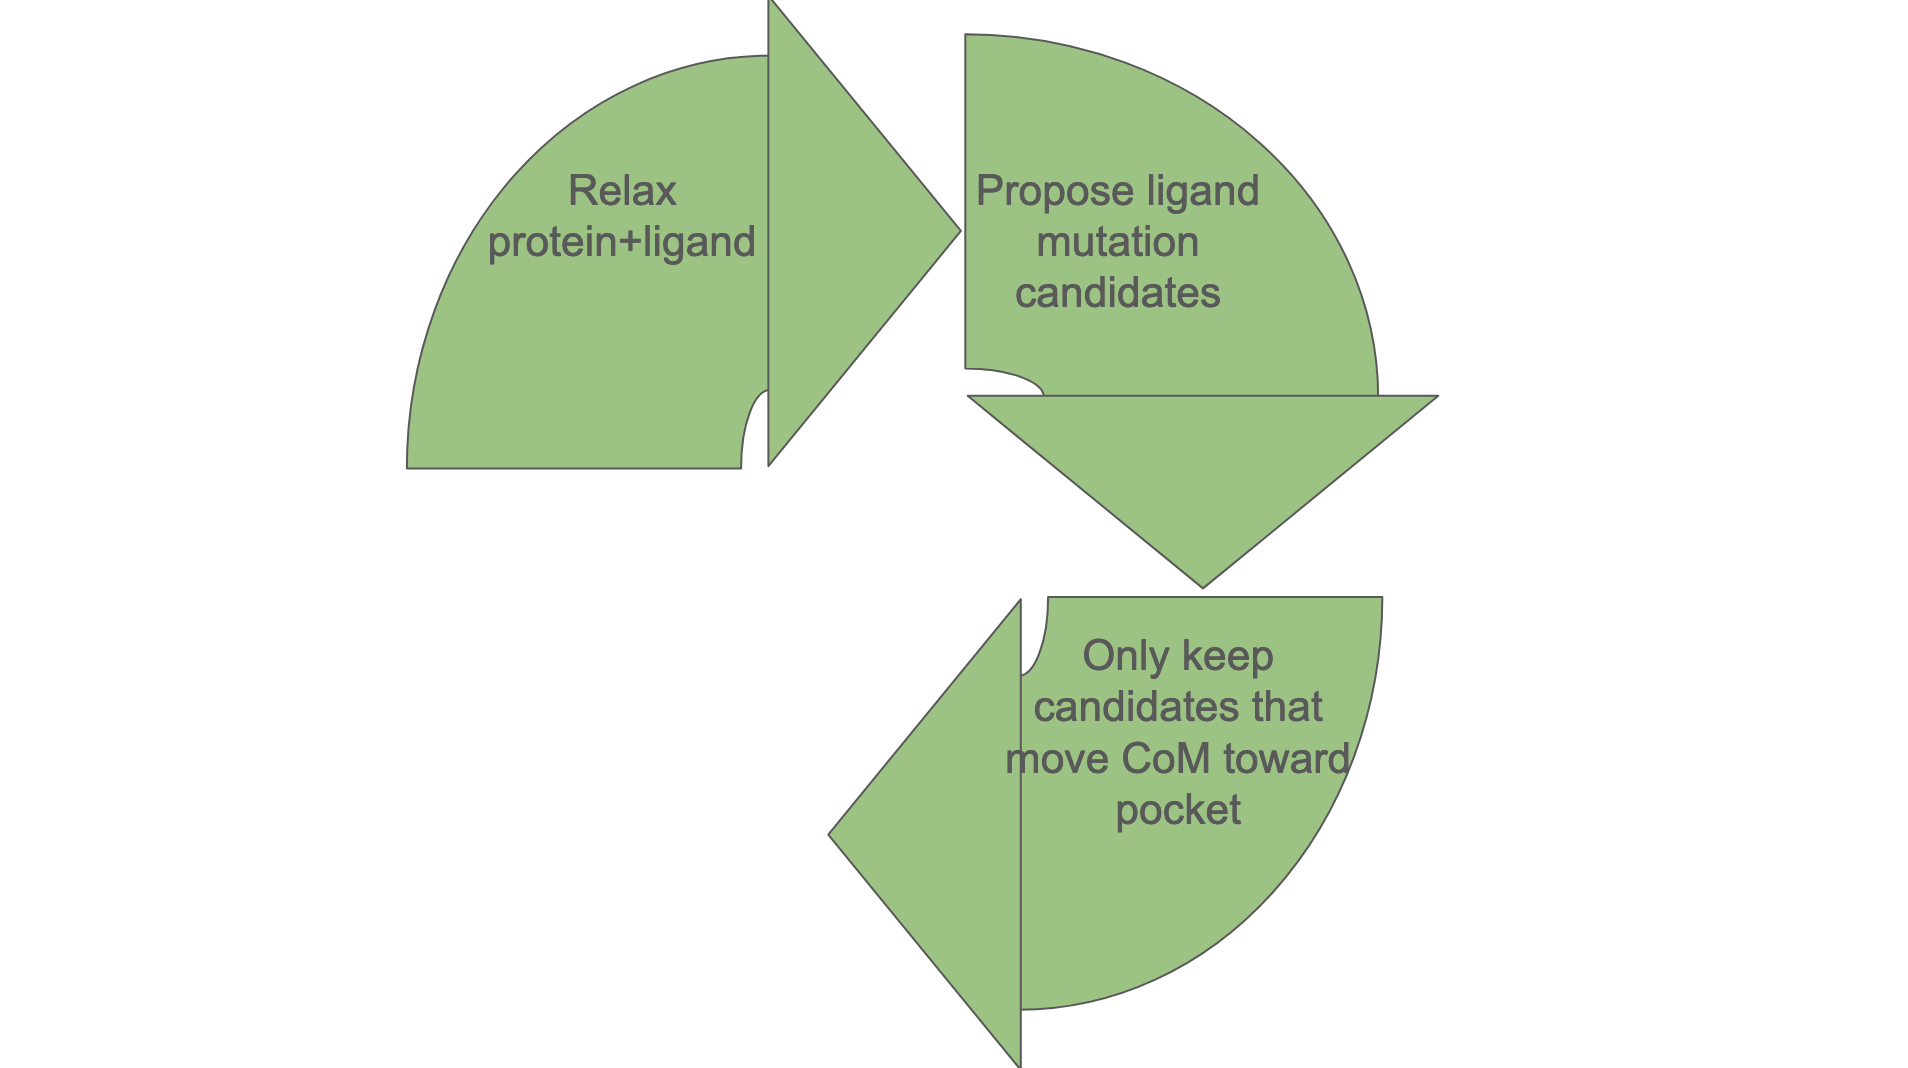

In [ ]:
def naive_objective(ligand):
    # CD of LEU76
    target_coord = (4., 1., 9.)
    ligand_com = np.mean(ligand.conformers[0], axis=0).m_as(unit.angstrom)
    return np.linalg.norm(target_coord - ligand_com)
    
for product in products:
    print(product.to_smiles(), naive_objective(product))

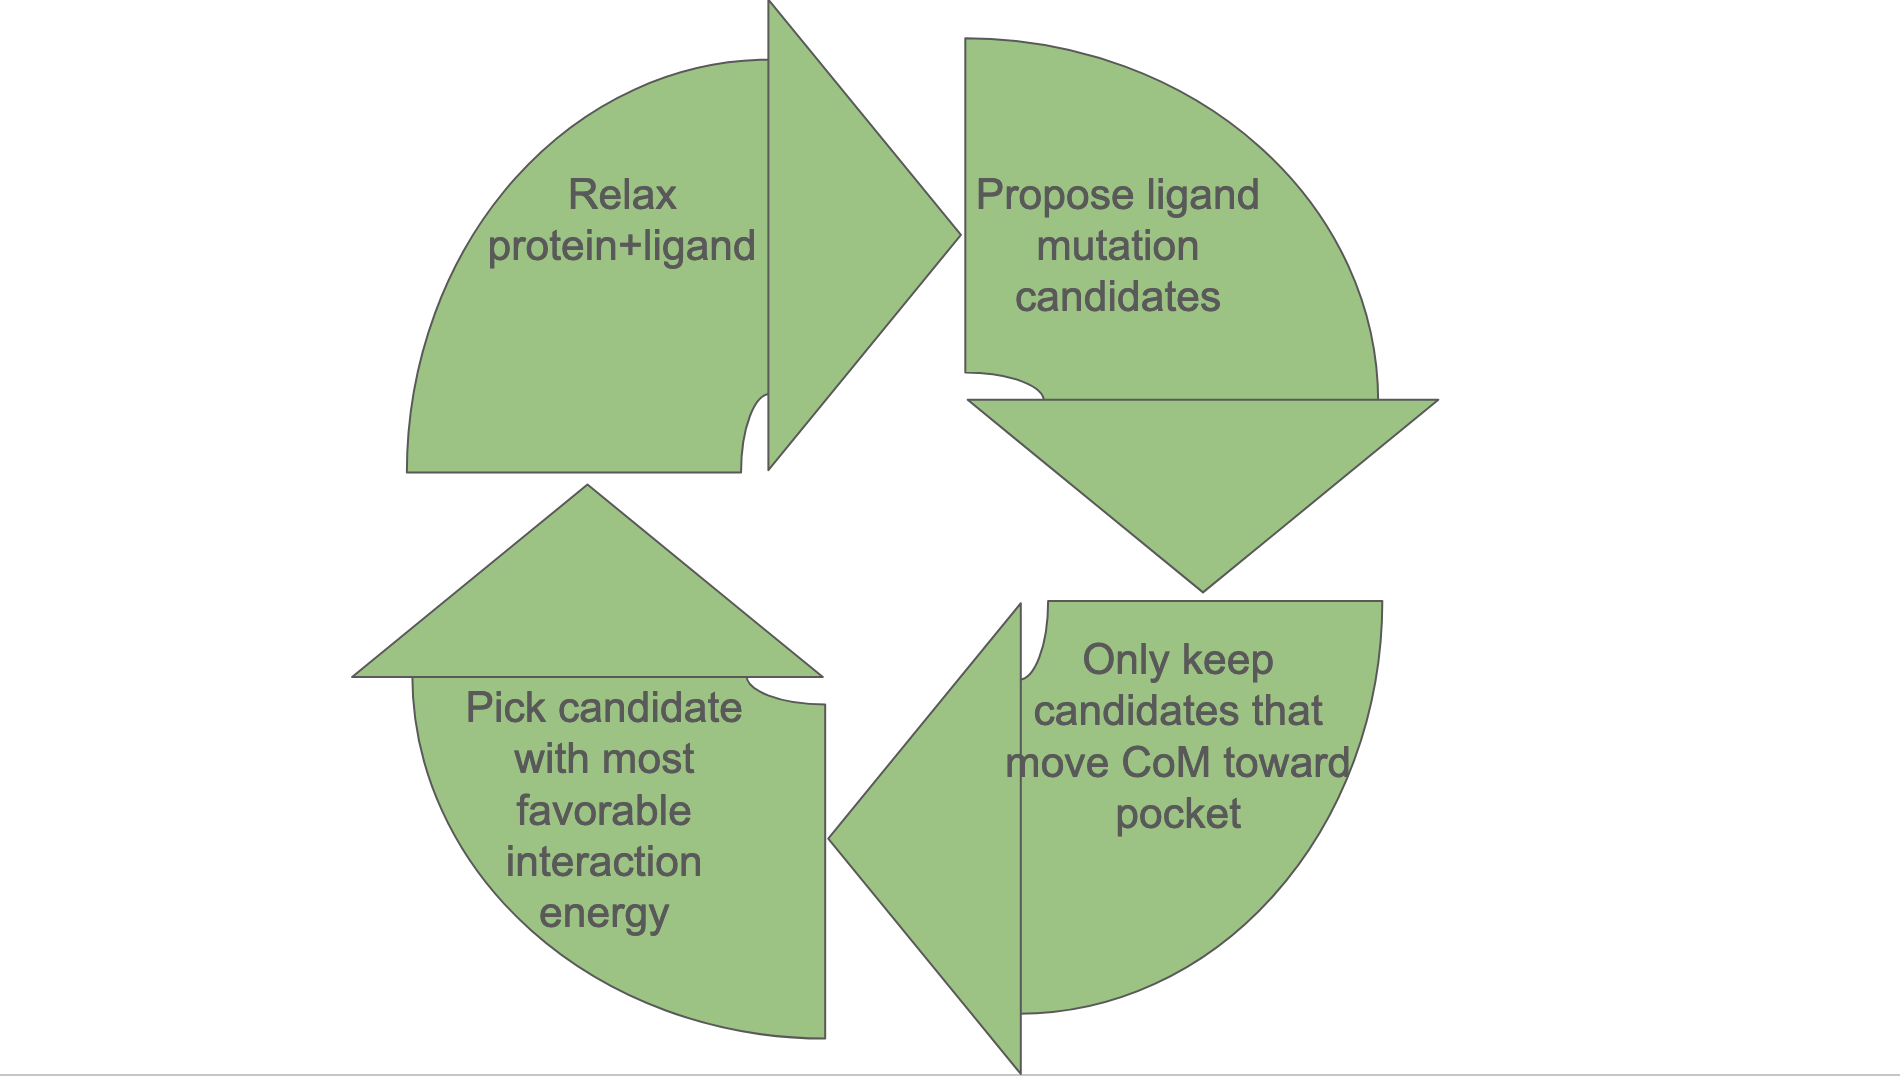

In [ ]:
def interaction_objective(
    ligand: Molecule,
    previous_complex: Topology,
    protein_energy: Quantity,
    protein_interchange: Interchange,
    force_field: ForceField = softened_ff,
) -> Quantity:
    """
    Interaction energy between ligand and all but the last molecule in previous_complex.

    """
    # NOTE: Using nagl again to rapidly assign charges
    ntkw = NAGLToolkitWrapper()
    ntkw.assign_partial_charges(ligand, "openff-gnn-am1bcc-0.1.0-rc.3.pt")

    # NOTE: Calculate ligand energy
    ligand_interchange = force_field.create_interchange(
        ligand.to_topology(), charge_from_molecules=[ligand]
    )
    ligand_energy = get_openmm_energies(ligand_interchange).total_energy

    # NOTE: Get expensive complex_interchange for cheap by reusing protein_interchange
    complex_interchange = protein_interchange.combine(ligand_interchange)
    complex_energy = get_openmm_energies(complex_interchange).total_energy

    interaction_energy = complex_energy - protein_energy - ligand_energy
    return interaction_energy

In [ ]:
candidates = [(top.molecule(1), 999)]
names = []

for idx in range(15):
    print(f"round {idx}")
    candidate, energy = candidates.pop(0)

    print(f"Relaxing candidate")
    name = str(idx)
    try:
        complex_interchange, state = relax_ligand(
            protein_interchange, candidate, sage, name=name
        )
    except ValueError as err:
        # If the simulation blows up, try with the next candidate
        print("Encountered error", err)
        continue
    names.append(name)
    relaxed_protein_positions = complex_interchange.positions[: protein.n_atoms]
    protein_interchange.positions = relaxed_protein_positions
    result_ligand = complex_interchange.topology.molecule(1)

    print(f"Computing protein point energy")
    protein_energy = single_point_energy(
        protein_simulation, relaxed_protein_positions, complex_interchange.box
    )

    print(f"generating mutations")
    mutations = mutate_ligand(result_ligand)
    print(f"pruning mutations by distance to target point")

    mutations = sorted(mutations, key=lambda x: naive_objective(x))[:3]
    print(f"evaluating mutations")
    candidates = []
    for mutation in mutations:
        print(f"computing {mutation}")

        candidates.append(
            (
                mutation,
                interaction_objective(
                    mutation,
                    complex_interchange.topology,
                    protein_energy,
                    protein_interchange,
                    softened_ff
                ),
            )
        )
        print(f"finished with energy {candidates[-1][1]}")

    candidates.sort(key=lambda x: x[1])

print("All done!")

In [ ]:

big_pdb = ""
for name in names:
    pdb = Path(f"{name}.pdb")
    big_pdb += "MODEL\n" + pdb.read_text() + "ENDMDL\n"
Path("relaxation_trajectory.pdb").write_text(big_pdb)

view = nglview.show_structure_file("relaxation_trajectory.pdb")
view.add_surface(
    selection="protein",
    opacity=0.5,
    opaqueBack=False,
)


def handler(change):
    view._remote_call(
        "setSelection",
        target="compList",
        args=[f"/{change['new']}"],
        kwargs=dict(component_index=0),
    )


play = widgets.Play(
    value=0,
    min=0,
    max=14,
    interval=500,
)
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=14,
)
slider.observe(handler, "value")
widgets.jslink((play, "value"), (slider, "value"))
controls = widgets.HBox([play, slider])
widgets.VBox([view, controls])

In [ ]:
view = nglview.show_file("14.pdb")
view.add_representation("surface", selection="protein", opacity=0.7, opaqueBack=False)
view.add_component("4hw3_D_aligned.pdb")
view

# We're about to make AM1BCC charge assignment a lot faster using our graph neural network tool, NAGL

In [ ]:
linezolid = Molecule.from_smiles("O=C1O[C@@H](CNC(=O)C)CN1c3cc(F)c(N2CCOCC2)cc3")

linezolid.visualize(show_all_hydrogens=False)

In [ ]:
#AmberToolsToolkitWrapper().assign_partial_charges(linezolid, "am1bcc")

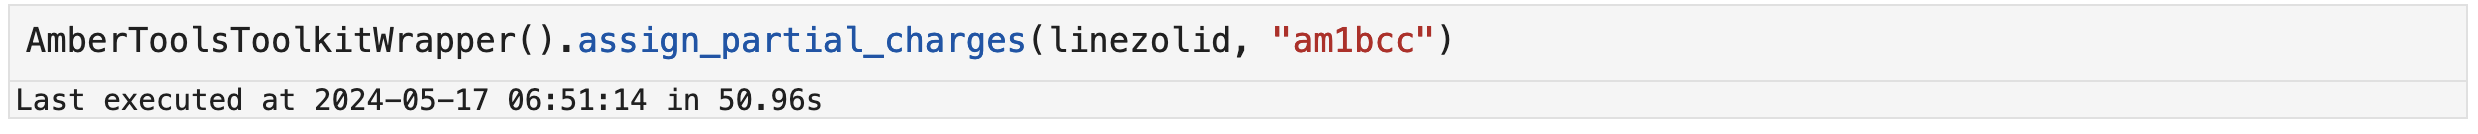

In [ ]:
#linezolid.to_file("linezolid_ambertools_charges.sdf", file_format="sdf")

In [ ]:
NAGLToolkitWrapper().assign_partial_charges(linezolid, 
                                            "openff-gnn-am1bcc-0.1.0-rc.3.pt")


In [ ]:
from matplotlib import pyplot
linezolid_at_charges = Molecule.from_file("linezolid_ambertools_charges.sdf")
linezolid_oe_charges = Molecule.from_file("linezolid_openeye_charges.sdf")
pyplot.subplot(1,3,1)
pyplot.bar(range(linezolid.n_atoms), 
           (linezolid_oe_charges.partial_charges - linezolid.partial_charges).m_as(unit.elementary_charge),
          )
pyplot.title("OE charges minus NAGL charges")
pyplot.ylabel("charge difference (elementary charge")
pyplot.yticks([-0.05, -0.025, 0, 0.025, 0.05])
pyplot.subplot(1,3,3)
pyplot.bar(range(linezolid.n_atoms), 
           (linezolid_oe_charges.partial_charges - linezolid_at_charges.partial_charges).m_as(unit.elementary_charge),
          )
pyplot.yticks([-0.05, -0.025, 0, 0.025, 0.05])

pyplot.title("OE charges minus AmberTools+RDKit charges")
pyplot.show()

In [ ]:
linezolid_15gly = Molecule.from_smiles("O=C1O[C@@H](CNC(=O)C)CN1c3cc(F)c(N2CCOCC2)cc3"+"NC(=O)C" * 15)
linezolid_15gly.visualize()

In [ ]:
%%time
NAGLToolkitWrapper().assign_partial_charges(linezolid_15gly, 
                                            "openff-gnn-am1bcc-0.1.0-rc.3.pt")